In [4]:
!pip install gdown --quiet
!mkdir -p ../.cache/checkpoints/

In [5]:
segrsnet_weights = {
    "segrsnet-14": {
        "whu": "https://drive.google.com/file/d/1zz8jQjkIGZ1n5zl13jMbEIBGJIyISPKV",
        "mass": "https://drive.google.com/file/d/1Fwgy0TJW02F8oO6xm_2JCsZjvLLakOj8",
        "deepglobe": "https://drive.google.com/file/d/1S8ZwGuVxQJybtF005ftnu1HLsDYzFJDw",
    },
    "segrsnet-26": {
        "whu": "https://drive.google.com/file/d/17926BDB5VFAuUr1IY3W8nJ2YrH1_jb7h",
        "mass": "https://drive.google.com/file/d/1R6Q396QgVy9ESwqDFFL9VyPD31bao6lc",
        "deepglobe": "https://drive.google.com/file/d/1YpLckvr5fcTZp0EDGqfGG1rWn-vXJQX1",
    },
    "segrsnet-50": {
        "whu": "https://drive.google.com/file/d/1RZvnv-8mjWl_RNr2Z8BfLJVKs6CImluz",
        "mass": "https://drive.google.com/file/d/1D94LoMLAaW2khlohSPl9NQgTJH7B5VhS",
        "deepglobe": "https://drive.google.com/file/d/13-6kn6iFUXAi0FqDXwv9pJDnhwv_mg3c",
    },
    "segrsnet-101": {
        "whu": "https://drive.google.com/file/d/1pG3lt5E4CPARXrKmrvq-VqwGtFm1f8pz",
        "mass": "https://drive.google.com/file/d/1zr7RskKoxaeFlVjOFLsBuUlafduq_dSC",
    },
}

segrsnet_resolutions = {
    "segrsnet-14": {"whu": 256, "mass": 256, "deepglobe": 1024},
    "segrsnet-26": {"whu": 256, "mass": 384, "deepglobe": 1024},
    "segrsnet-50": {"whu": 384, "mass": 384, "deepglobe": 1024},
    "segrsnet-101": {
        "whu": 384,
        "mass": 384,
    },
}


In [6]:
import os
import sys

sys.path.append("../")
import gdown
from utils.utils import convert_googledrive_url
import torch
from monai.inferers import SlidingWindowInferer
from PIL import Image
import numpy as np
from torchvision import transforms as T
import matplotlib.pyplot as plt
import time

CHECK_POINT_PATH = "../.cache/checkpoints/"

# create .cache folder
DATASET = "whu"
# Available models: segrsnet-14, segrsnet-26, segrsnet-50, segrsnet-101
VERSION = "101"  # Choose segrsnet-14

ENCODER_NAME = f"segrsnet-{VERSION}"

In [7]:
# Download checkpoint
url = segrsnet_weights[ENCODER_NAME][DATASET]
url = convert_googledrive_url(url)
print(f"Downloading {url}")
PTH_PATH = CHECK_POINT_PATH + f"{ENCODER_NAME}-{DATASET}-model.pth"

if not os.path.exists(PTH_PATH):
    gdown.download(url, PTH_PATH, quiet=False)
else:
    print(f"File {PTH_PATH} already exists")

model = torch.load(PTH_PATH, map_location=torch.device("cpu"))

File ../.cache/checkpoints/segrsnet-101-whu-model.pth already exists


/Users/aieson/miniconda3/envs/SegRSNetTest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
torch.save(model, CHECK_POINT_PATH + f"{ENCODER_NAME}-{DATASET}-model.pth")

In [9]:
# use monai to predict the fully resolution image
sliding_window_inferer = SlidingWindowInferer(
    roi_size=(segrsnet_resolutions[ENCODER_NAME][DATASET]) * 2, sw_batch_size=4
)

# do inference
model.eval()

now_device = torch.device("cpu")

if torch.cuda.is_available():
    now_device = torch.device("cuda")
elif torch.backends.mps.is_built():
    now_device = torch.device("mps")

print(f"Using {now_device} for inference")
model = model.to(device=now_device)

IMG_PATH = "./test.tif"

as_tensor = T.Compose(
    [
        T.ToPILImage(),
        T.ToTensor(),
    ]
)
def infer(img_path):
    img = Image.open(img_path)
    img = img.convert("RGB")
    img = np.array(img)
    img = as_tensor(img).unsqueeze(0)
    img = img.to(device=now_device)
    with torch.no_grad():
        pred = sliding_window_inferer(img, model)
    return pred

t_ = time.time()
pred = infer(IMG_PATH).sigmoid().squeeze(0).squeeze(0).cpu().numpy() > 0.5
print(f"Inference time: {time.time() - t_}s")

Using mps for inference
Inference time: 2.155219316482544s


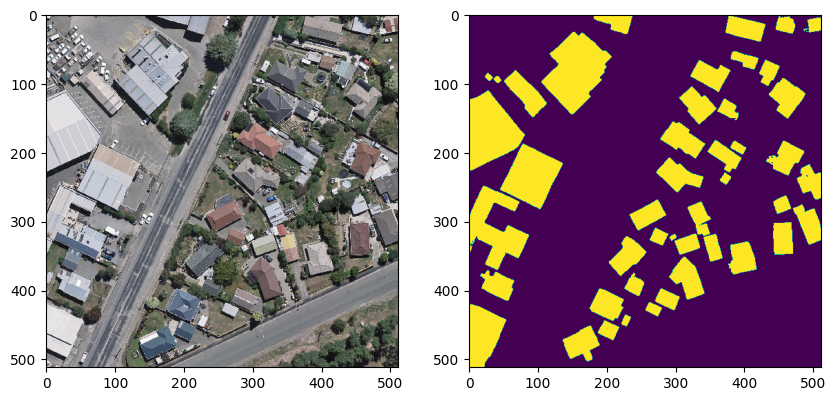

In [10]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(IMG_PATH))
plt.subplot(1, 2, 2)
plt.imshow(pred)
plt.show()